<a href="https://colab.research.google.com/github/Snomty/fast_api_demo/blob/main/13_3_FastAPI_and_ML_(penguins).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastAPI и ML-модель. Пингвины

## Импорт библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

## Обработка данных и построение пайплайна

In [ ]:
data = pd.read_csv('https://github.com/evgpat/datasets/raw/refs/heads/main/penguins.csv')
data = data.dropna()
data

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
6,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
350,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
351,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
352,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female
353,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [ ]:
le = preprocessing.LabelEncoder()

X = data[["bill_length_mm", "flipper_length_mm"]]
le.fit(data["species"])
y = le.transform(data["species"])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [ ]:
clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=11))]
)

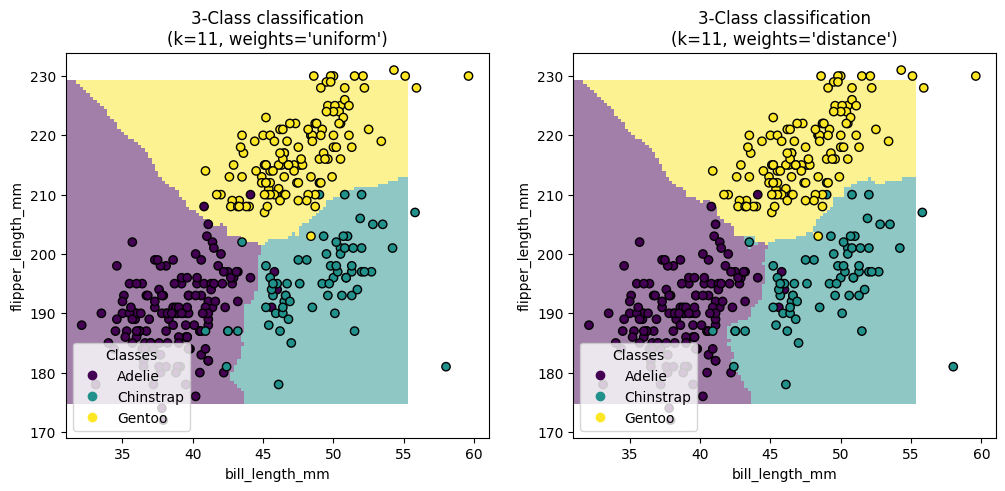

In [ ]:
import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay

_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train, y_train)

    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel="bill_length_mm",
        ylabel="flipper_length_mm",
        shading="auto",
        alpha=0.5,
        ax=ax,
    )

    scatter = disp.ax_.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors="k")

    disp.ax_.legend(
        scatter.legend_elements()[0],
        le.classes_,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()

Confusion matrix, without normalization
[[35  1  1]
 [ 0 17  0]
 [ 0  0 31]]
Normalized confusion matrix
[[0.95 0.03 0.03]
 [0.   1.   0.  ]
 [0.   0.   1.  ]]


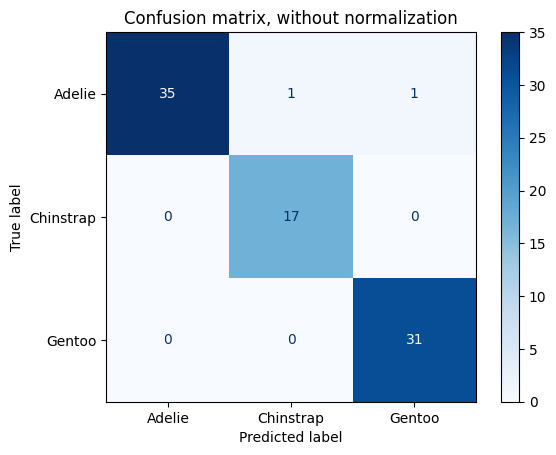

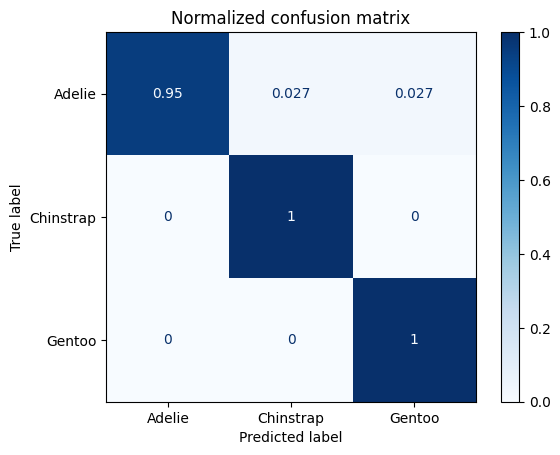

In [ ]:
np.set_printoptions(precision=2)

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=le.classes_,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
param = {
    "bill_length_mm": [195],
    "flipper_length_mm": [195]
    }

clf.predict(pd.DataFrame(param))

array([2])

In [ ]:
type(X_test)

pandas.core.frame.DataFrame

In [ ]:
result = clf.predict([[195,195]])
le.inverse_transform(result)[0]

## Реализация веб-сервиса

In [ ]:
%%writefile main.py

from fastapi import FastAPI, UploadFile, BackgroundTasks
from contextlib import asynccontextmanager

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


PATH = 'https://github.com/evgpat/datasets/raw/refs/heads/main/penguins.csv'
ml_models = {}

def penguins_pipeline():
    data = pd.read_csv(PATH)
    data = data.dropna()

    le = preprocessing.LabelEncoder()
    X = data[["bill_length_mm", "flipper_length_mm"]]
    le.fit(data["species"])
    y = le.transform(data["species"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    clf = Pipeline(
        steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=11))]
    )
    clf.set_params().fit(X_train, y_train)

    return clf, le


@asynccontextmanager
async def lifespan(app: FastAPI):
    clf, le = penguins_pipeline()

    ml_models["clf"] = clf
    ml_models["le"] = le

    yield

    ml_models.clear()

app = FastAPI(lifespan=lifespan)


@app.get("/")
async def root():
    return {
        "Name": "Penguins Prediction",
        "description": "This is a penguins prediction model based on the bill length and flipper length of the bird.",
    }

@app.get("/predict/")
async def predict(bill_length_mm: float = 0.0, flipper_length_mm: float = 0.0):
    param = {
                "bill_length_mm": bill_length_mm,
                "flipper_length_mm": flipper_length_mm
            }
    if bill_length_mm <=0.0 or flipper_length_mm <=0.0:
        return {
            "parameters": param,
            "error message": "Invalid input values",
        }
    else:
        result = ml_models["clf"].predict([[bill_length_mm, flipper_length_mm]])
        return {
            "parameters": param,
            "result": ml_models["le"].inverse_transform(result)[0],
        }

Writing main.py


In [ ]:
!uvicorn main:app & npx localtunnel --port 8000 --subdomain fastapi & wget -q -O - https://loca.lt/mytunnelpassword